In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs

## Original file

In [2]:
dm = xr.open_dataset('data/CD_1.nc')
dm['lon'] = ((dm.lon + 180) % 360) - 180
dm

<xarray.Dataset>
Dimensions:  (rlat: 266, rlon: 232)
Coordinates:
    lon      (rlat, rlon) float64 144.8 145.1 145.3 ... -38.98 -39.17 -39.37
    lat      (rlat, rlon) float64 ...
Dimensions without coordinates: rlat, rlon
Data variables:
    mmask    (rlat, rlon) float64 ...
Attributes: (12/19)
    CDI:                        Climate Data Interface version 1.9.4 (http://...
    Conventions:                CF-1.4
    history:                    Thu Nov 19 23:37:38 2020: /HOME/opt/package/n...
    DOMAIN_number_total:        1
    DOMAIN_number:              0
    DOMAIN_dimensions_ids:      [1 2]
    ...                         ...
    history_of_appended_files:  Mon Oct  2 22:18:28 2017: Appended file mesh_...
    NCO:                        "4.5.2"
    CDO:                        Climate Data Operators version 1.9.4 (http://...
    title:                      Arctic Ocean basin and Canadian Arctic land s...
    institution:                Canadian Centre for Climate Modelling and Ana...
    comment:                    For: Recent and projected atmospheric trends ...

In [3]:
levels = np.unique(dm.mmask)
levels

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,
        9., 10., 11., 12., 13., 14., 15.])

## Plot masks

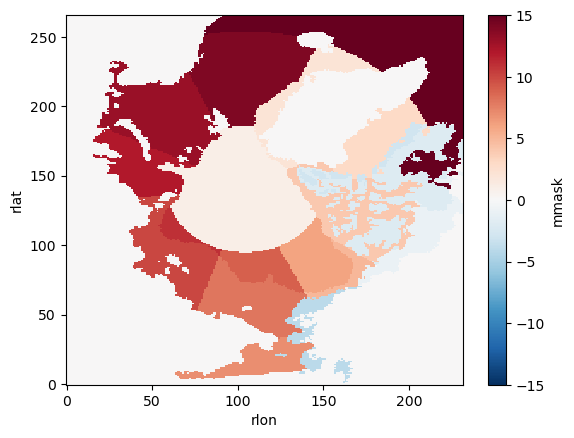

In [5]:
dm.mmask.plot()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


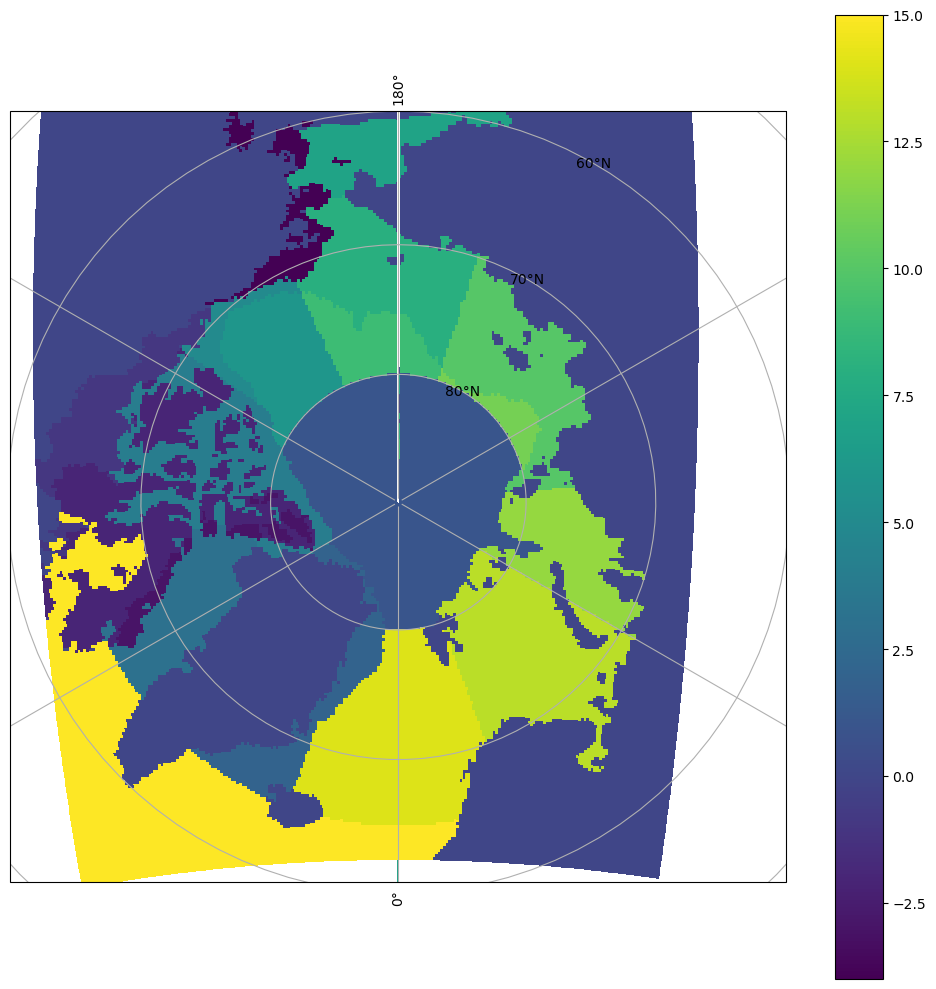

In [11]:
fig, ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.NorthPolarStereo()})
# fig, ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})

plt.pcolormesh(
    # dm.lon,
    np.unwrap(dm.lon,axis=0,period=360), 
    dm.lat, 
    dm.mmask,
    # dm.mmask.where(dm.mmask==1),
    transform=ccrs.PlateCarree(),
    # cmap=plt.colormaps['Blues_r']
        )
plt.colorbar()

ax.set_extent( [-180,180, 60,90], ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
# ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
fig.tight_layout()

## Regrid : interpolation

In [12]:
from scipy.interpolate import NearestNDInterpolator

maskInt = NearestNDInterpolator( 
    list(zip( np.ravel(dm.lon.values), np.ravel(dm.lat.values) )), # points
    np.ravel(dm.mmask.values) # data
)


## Gali 2019

In [13]:
import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))
file = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc'
ds = xr.open_dataset(s3.open(file))
ds

<xarray.Dataset>
Dimensions:      (pixel: 96668, year: 1, period: 46)
Coordinates:
  * year         (year) float64 2.01e+03
Dimensions without coordinates: pixel, period
Data variables:
    longitude    (pixel) float64 ...
    latitude     (pixel) float64 ...
    startjulday  (period) float64 ...
    endjulday    (period) float64 ...
    dms          (period, year, pixel) float64 ...

In [14]:
dmaskGali = xr.Dataset(data_vars={'mask':(['pixel'], maskInt(ds.longitude, ds.latitude)) }, 
                         coords={ "latitude": (['pixel'], ds.latitude.values), "longitude": (['pixel'], ds.longitude.values) } )

dmaskGali
# dmaskGali.to_netcdf('cordexMaskGali19.nc')

In [15]:
# griding for plotting
import functions as f
maskGaligridded = f.interGali(dmaskGali,'mask')

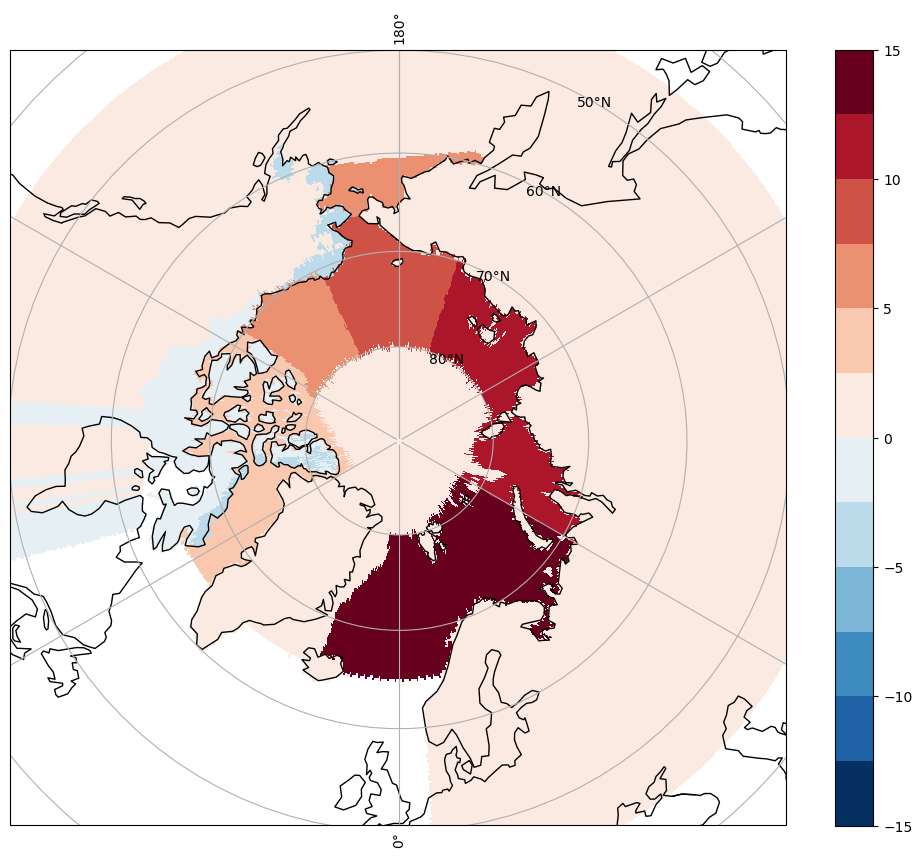

In [16]:
fig, ax = plt.subplots(figsize=(10,10),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
maskGaligridded.plot( 
        ax = ax,
        cbar_kwargs={ 'orientation':'vertical', 'shrink':.8},
        transform=ccrs.PlateCarree(),
        levels=15
    )
ax.set_extent( [-180,180, 50,90], ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.coastlines()
fig.tight_layout()    

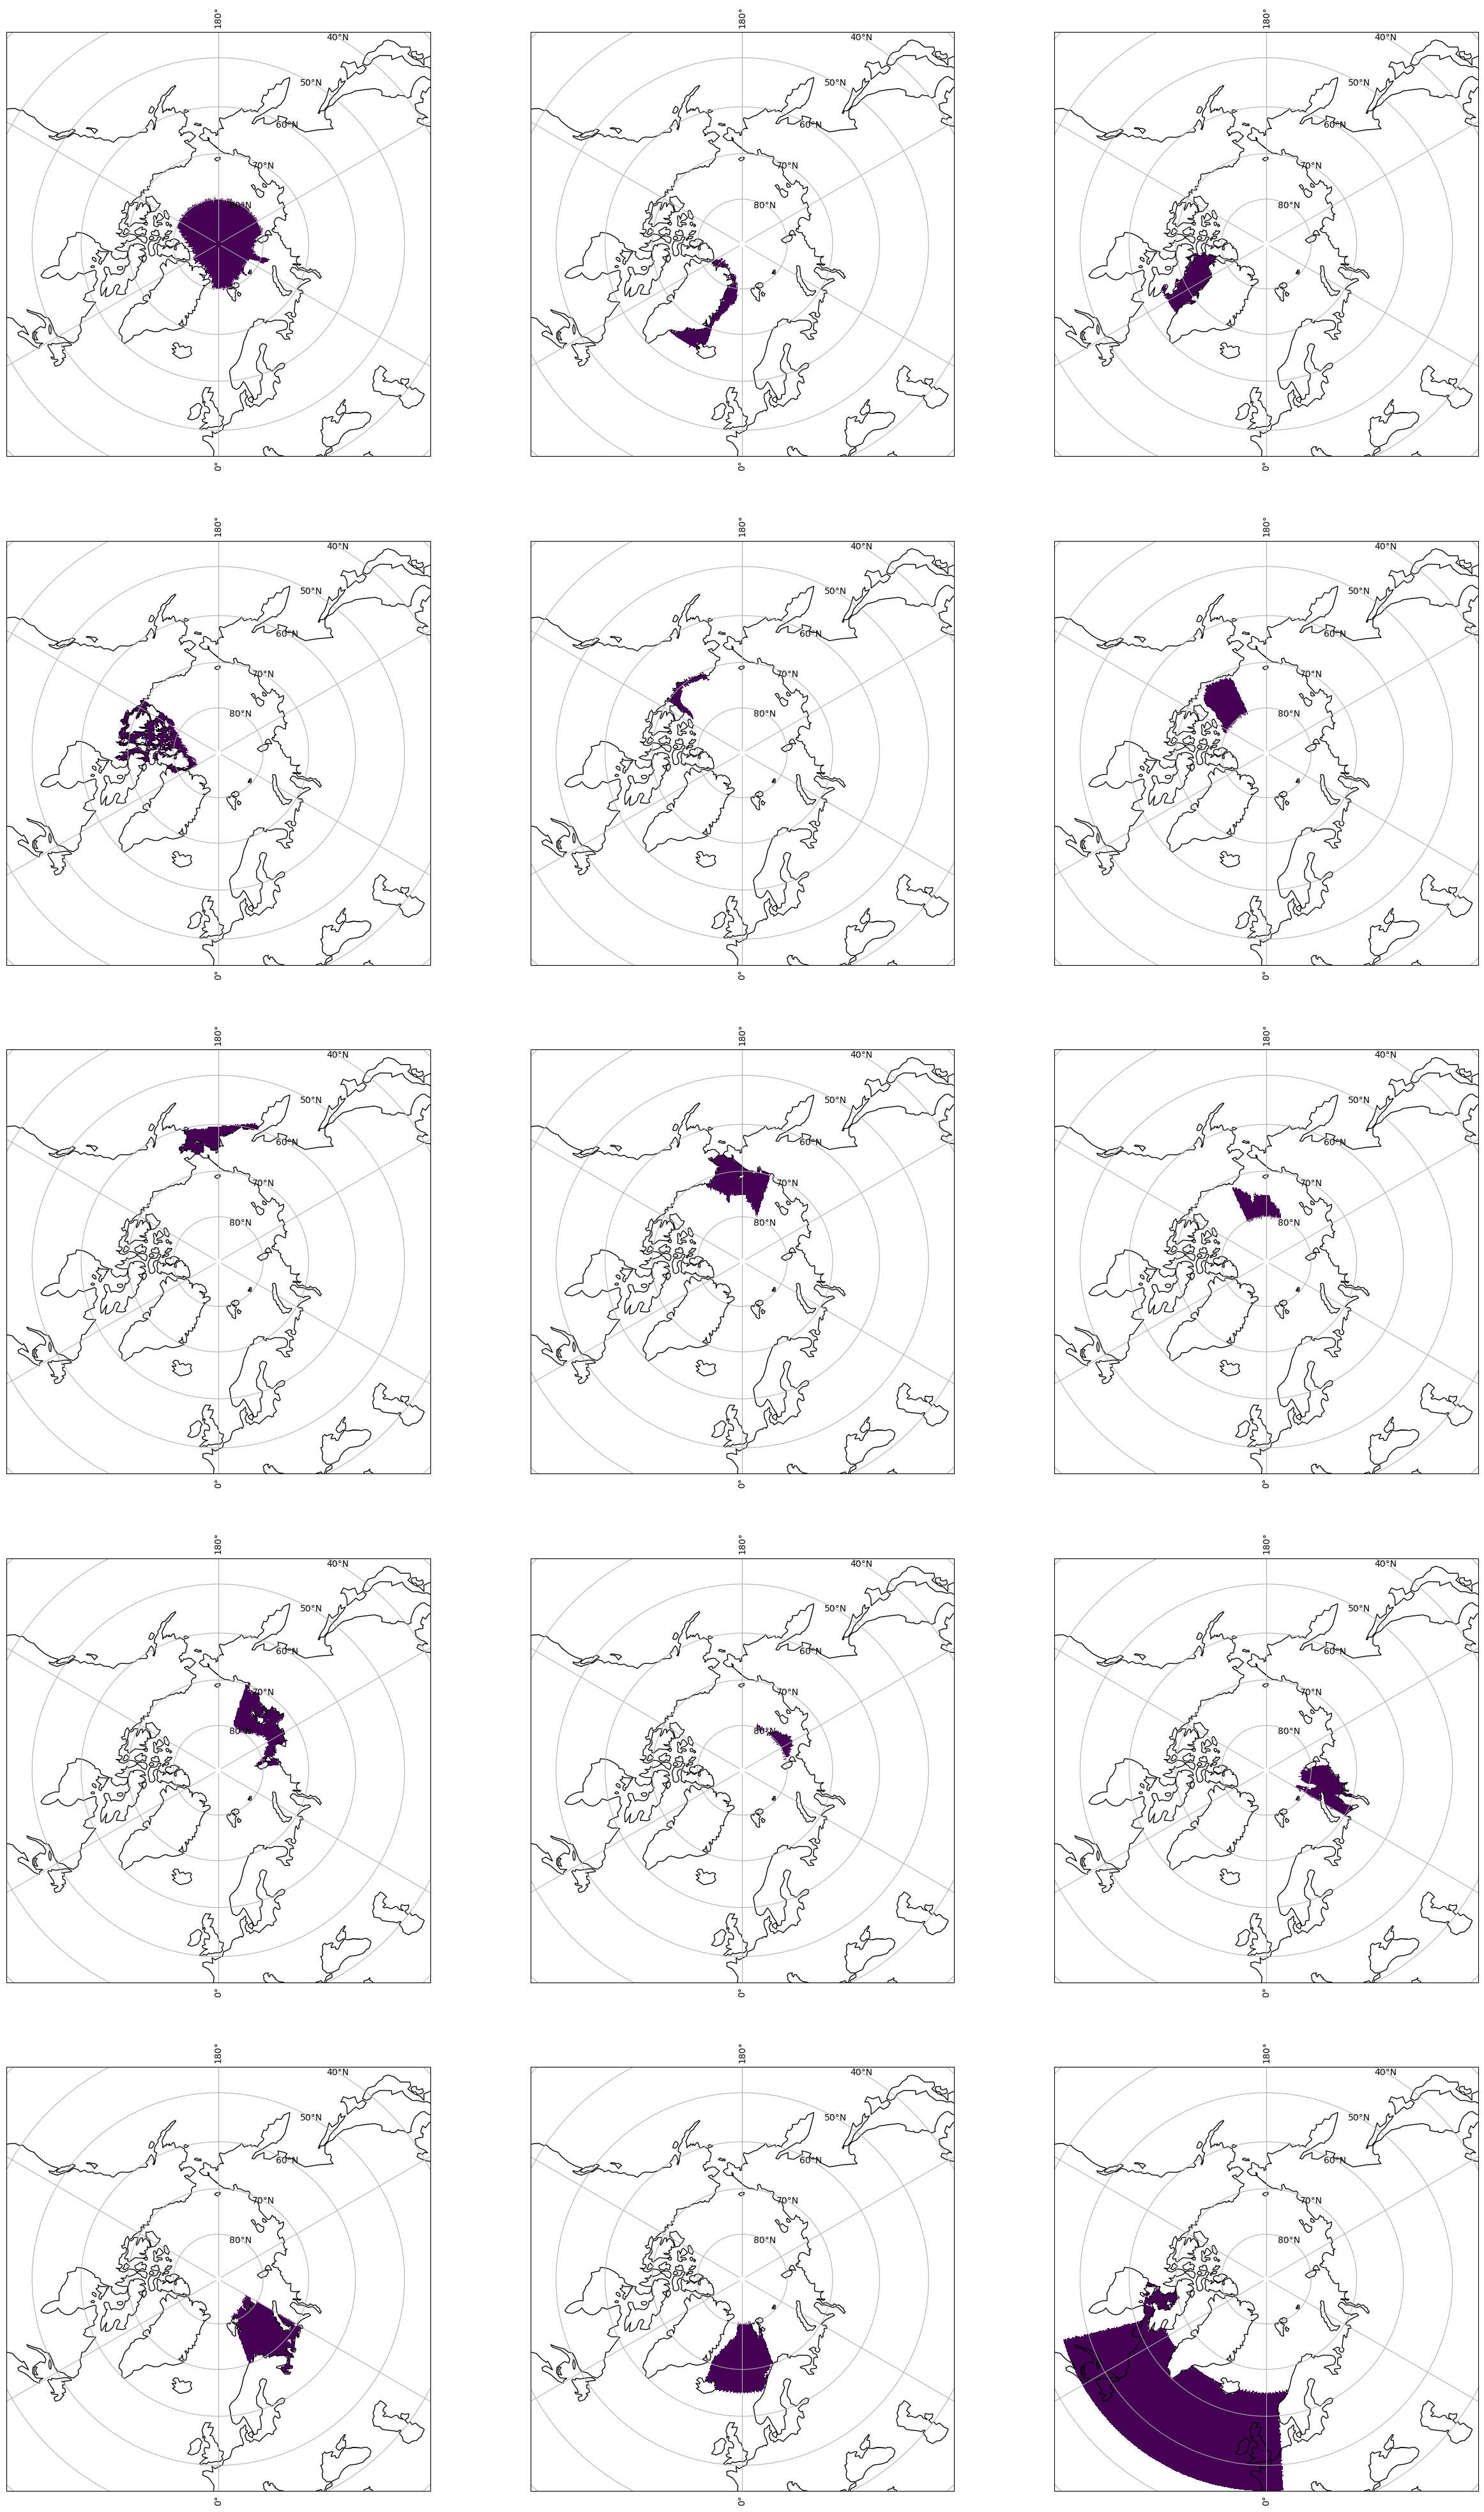

In [17]:
fig, ax = plt.subplots(5,3,figsize=(30,50),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})

ax=ax.ravel()
for im in range(15):
    ax[im].pcolormesh( maskGaligridded.lon, maskGaligridded.lat,
        maskGaligridded.where(maskGaligridded==im+1),
        transform=ccrs.PlateCarree(),
    )
    ax[im].gridlines(draw_labels=True)
    ax[im].coastlines()
    
    
